In [141]:
import os
import fiona
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import geopandas as geopd

viridis = cm.get_cmap('viridis', 6)

## Data Informations
All data shared from 
[CapitalBikeShare](https://www.capitalbikeshare.com/system-data)

## Tasks to make
- Identify the variables that most impact hourly ridership
- Develop a model to predict hourly bikeshare demand in the Greater Washington DC region based on historical ridership and weather data for next year
- Get a total of members and casual clients
- Explore how many clients use in normal work/study hour 6~9 12~14 18~20
- Get the most stations used
- Get the most bikes used by the time used


In [81]:
dataframe_stations_raw = pd.read_json('https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json', orient='values')

In [82]:
dataframe_stations = dataframe_stations_raw.copy()
dataframe_stations = pd.DataFrame(dataframe_stations.data.stations).set_index('station_id')
print('Stations Length: ',len(dataframe_stations))
dataframe_stations.head()

Stations Length:  649


,electric_bike_surcharge_waiver,external_id,region_id,eightd_station_services,capacity,lat,lon,has_kiosk,eightd_has_key_dispenser,name,station_type,short_name,rental_uris,legacy_id,rental_methods
station_id,,,,,,,,,,,,,,,
1,False,082469cc-1f3f-11e7-bf6b-3863bb334450,41,[],15,38.858971,-77.053230,True,False,Eads St & 15th St S,classic,31000,{'android': 'https://dc.lft.to/lastmile_qr_sca...,1,"[KEY, CREDITCARD]"
2,False,08246b69-1f3f-11e7-bf6b-3863bb334450,41,[],11,38.857250,-77.053320,True,False,18th St & S Eads St,classic,31001,{'android': 'https://dc.lft.to/lastmile_qr_sca...,2,"[KEY, CREDITCARD]"
3,False,08246c35-1f3f-11e7-bf6b-3863bb334450,41,[],17,38.856425,-77.049232,True,False,Crystal Dr & 20th St S,classic,31002,{'android': 'https://dc.lft.to/lastmile_qr_sca...,3,"[KEY, CREDITCARD]"
4,False,08246cd5-1f3f-11e7-bf6b-3863bb334450,41,[],16,38.861056,-77.049417,True,False,Crystal Dr & 15th St S,classic,31003,{'android': 'https://dc.lft.to/lastmile_qr_sca...,4,"[KEY, CREDITCARD]"
5,False,08246d68-1f3f-11e7-bf6b-3863bb334450,41,[],12,38.857866,-77.059490,True,False,Aurora Hills Cmty Ctr / 18th St & S Hayes St,classic,31004,{'android': 'https://dc.lft.to/lastmile_qr_sca...,5,"[KEY, CREDITCARD]"


In [83]:
dataframe_tripdata_raw = pd.read_csv('2016Q1-capitalbikeshare-tripdata.csv')
print('Raw Trip Length: ',len(dataframe_tripdata_raw))
dataframe_tripdata_raw.head()

Raw Trip Length:  552399


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,166,2016-01-01 00:06:58,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member
1,448,2016-01-01 00:10:20,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member
2,715,2016-01-01 00:13:52,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member
3,213,2016-01-01 00:15:29,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member
4,872,2016-01-01 00:16:16,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member


In [84]:
dataframe_tripdata = dataframe_tripdata_raw.copy()
print('Copy Trip Length: ',len(dataframe_tripdata))
dataframe_tripdata.head()

Copy Trip Length:  552399


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,166,2016-01-01 00:06:58,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member
1,448,2016-01-01 00:10:20,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member
2,715,2016-01-01 00:13:52,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member
3,213,2016-01-01 00:15:29,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member
4,872,2016-01-01 00:16:16,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member


### Total of clients by the type

In [85]:
dataframe_membertype = dataframe_tripdata.groupby('Member type')['Duration'].count().reset_index()
dataframe_membertype.rename(columns={'Duration':'Total'}, inplace=True)
dataframe_membertype.head()

,Member type,Total
0,Casual,84967
1,Member,467432


In [86]:
dataframe_casualclients = dataframe_tripdata[dataframe_tripdata['Member type'] == 'Casual']
print('Length: ',len(dataframe_casualclients))
dataframe_casualclients.head()

Length:  84967


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
5,859,2016-01-01 00:16:18,2016-01-01 00:30:37,31041,Prince St & Union St,31048,King St Metro South,W01122,Casual
11,278,2016-01-01 00:27:26,2016-01-01 00:32:05,31231,14th & D St NW / Ronald Reagan Building,31262,11th & F St NW,W00922,Casual
23,2018,2016-01-01 00:32:51,2016-01-01 01:06:30,31246,M St & Pennsylvania Ave NW,31513,Rhode Island Ave & V St NE,W22120,Casual
35,1285,2016-01-01 00:39:53,2016-01-01 01:01:18,31632,15th & F St NE,31632,15th & F St NE,W21072,Casual
39,1187,2016-01-01 00:43:49,2016-01-01 01:03:36,31258,Lincoln Memorial,31077,Iwo Jima Memorial/N Meade & 14th St N,W20562,Casual


In [87]:
dataframe_memberclients = dataframe_tripdata[dataframe_tripdata['Member type'] == 'Member']
print('Length: ',len(dataframe_memberclients))
dataframe_memberclients.head()

Length:  467432


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,166,2016-01-01 00:06:58,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member
1,448,2016-01-01 00:10:20,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member
2,715,2016-01-01 00:13:52,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member
3,213,2016-01-01 00:15:29,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member
4,872,2016-01-01 00:16:16,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member


In [88]:
dataframe_casual_by_station = dataframe_casualclients.groupby('Start station number')['Member type'].count().reset_index()
dataframe_casual_by_station.rename(columns={'Start station number':'station_id','Member type':'total'}, inplace=True)
print('Length: ',len(dataframe_casual_by_station))
dataframe_casual_by_station.head()

Length:  355


,station_id,total
0,31000,73
1,31001,75
2,31002,225
3,31003,199
4,31004,16


In [89]:
dataframe_member_by_station = dataframe_memberclients.groupby('Start station number')['Member type'].count().reset_index()
dataframe_member_by_station.rename(columns={'Start station number':'station_id','Member type':'total'}, inplace=True)
print('Length: ',len(dataframe_member_by_station))
dataframe_member_by_station.head()

Length:  370


,station_id,total
0,31000,226
1,31001,294
2,31002,695
3,31003,713
4,31004,657


## Morning Clients
6am ~ 9am

In [90]:
dataframe_morning_clients = dataframe_tripdata.copy()
dataframe_morning_clients['Start date'] = pd.to_datetime(dataframe_morning_clients['Start date'])
dataframe_morning_clients.set_index('Start date',inplace=True)
dataframe_morning_clients = dataframe_morning_clients.between_time('06:00:00','09:00:00')
print('Total Morning Clients: ',len(dataframe_morning_clients))
# dataframe_morning_clients.head()

Total Morning Clients:  95095


## Lunch Clients 
12am ~ 14pm

In [91]:
dataframe_lunch_clients = dataframe_tripdata.copy()
dataframe_lunch_clients['Start date'] = pd.to_datetime(dataframe_lunch_clients['Start date'])
dataframe_lunch_clients.set_index('Start date',inplace=True)
dataframe_lunch_clients = dataframe_lunch_clients.between_time('12:00:00','14:00:00')
print('Total LunchTime Clients: ',len(dataframe_lunch_clients))
# dataframe_lunch_clients.head()

Total LunchTime Clients:  61398


## Go Night Clients
18pm ~ 20pm

In [92]:
dataframe_night_clients = dataframe_tripdata.copy()
dataframe_night_clients['Start date'] = pd.to_datetime(dataframe_night_clients['Start date'])
dataframe_night_clients.set_index('Start date',inplace=True)
dataframe_night_clients = dataframe_night_clients.between_time('18:00:00','20:00:00')
print('Total Night Clients: ',len(dataframe_night_clients))
# dataframe_night_clients.head()

Total Night Clients:  85083


# Most used stations
top 10 stations

In [93]:
dataframe_sort_stations = dataframe_tripdata.groupby('Start station number')['Duration'].count().reset_index()
dataframe_sort_stations.rename(columns={'Start station number':'station_id', 'Duration':'Total'}, inplace=True)
dataframe_sort_stations.sort_values(by=['Total'],axis=0,ascending=False,inplace=True)
dataframe_sort_stations[:10]

,station_id,Total
274,31623,13120
123,31200,9560
180,31258,9388
169,31247,8138
163,31241,7479
124,31201,7401
101,31101,6568
151,31229,6491
264,31613,5649
136,31214,5514


# Most used bikes
top 10 of bikes

In [94]:
dataframe_sort_bikes = dataframe_tripdata.groupby('Bike number')['Duration'].count().reset_index()
dataframe_sort_bikes.rename(columns={'Bike number':'bike_id', 'Duration':'Total'}, inplace=True)
dataframe_sort_bikes.sort_values(by=['Total'],axis=0,ascending=False,inplace=True)
dataframe_sort_bikes[:10]

,bike_id,Total
3017,W21797,345
3400,W22227,337
2845,W21609,337
38,W00045,332
1694,W20384,328
1931,W20632,324
294,W00346,322
1561,W20242,322
2489,W21239,320
2440,W21186,320


## Time of use bike
Trying to find the total of used bikes
looks like it's in seconds

In [95]:
dataframe_time_used = dataframe_tripdata.groupby('Bike number')['Duration'].sum().reset_index()
dataframe_time_used.sort_values(by=['Duration'],axis=0,ascending=False,inplace=True)
dataframe_time_used

,Bike number,Duration
1273,W01410,386143
1436,W20098,384611
2503,W21253,368121
364,W00420,367593
2338,W21068,366573
...,...,...
2039,W20745,463
1492,W20162,344
820,W00919,262
283,W00335,251


# Time for plot the data
Distribution Subscriber Type

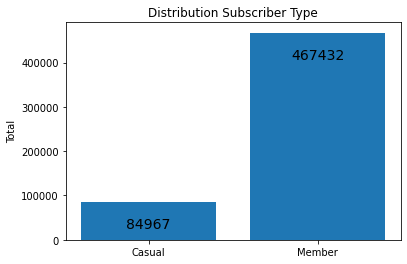

In [145]:
plt.bar(x=dataframe_membertype["Member type"], height=dataframe_membertype["Total"])
for index,data in enumerate(dataframe_membertype["Total"]):
    plt.text(x=index, y=data-50000, s=f"{data}" , fontsize=14, horizontalalignment='center', verticalalignment='center')

plt.ylabel("Total")
plt.title("Distribution Subscriber Type")
plt.show()

## Import maps with GeoPandas
Search for Virginia USA

In [97]:
url = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_1_states_provinces_shp.geojson"
df = geopd.read_file(url)
map_virginia = df[df['diss_me'] == 3552]
map_virginia

,scalerank,adm1_code,diss_me,adm1_cod_1,iso_3166_2,wikipedia,sr_sov_a3,sr_adm0_a3,iso_a2,adm0_sr,...,area_sqkm,sameascity,labelrank,featurec_1,admin,name_len,mapcolor9,mapcolor13,featureclass,geometry
39,2,USA-3552,3552,USA-3552,US-VA,http://en.wikipedia.org/wiki/Virginia,US1,USA,US,6,...,0,-99,0,Admin-1 scale rank,United States of America,8,1,1,Admin-1 scale rank,"MULTIPOLYGON (((-75.37754 38.01538, -75.94003 ..."


<AxesSubplot:>

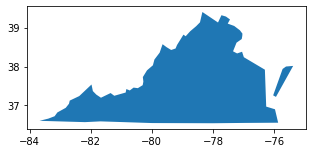

In [98]:
map_virginia.plot(figsize=(5, 5))